In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [23]:
# Load maternal data
maternal_df = pd.read_csv("database/additional_db.csv")

# Load fetal signal data
signal_dir = "database/signals"
sequence_length = 2400
fetal_data, maternal_data, labels = [], [], []

for _, row in maternal_df.iterrows():
    patient_id = str(int(row["ID"]))
    label = row["Deliv. type"]
    maternal_features = row.drop(["ID", "Deliv. type"]).values

    signal_path = os.path.join(signal_dir, f"{patient_id}.csv")
    if os.path.exists(signal_path):
        df = pd.read_csv(signal_path)
        if "FHR" in df.columns and "UC" in df.columns:
            signal = df[["FHR", "UC"]].interpolate(limit_direction='both').values[:sequence_length]
            if len(signal) < sequence_length:
                padding = np.zeros((sequence_length - len(signal), 2))
                signal = np.vstack([signal, padding])
            fetal_data.append(signal)
            maternal_data.append(maternal_features)
            labels.append(label)

X_fetal = np.array(fetal_data)
X_maternal = np.array(maternal_data)
y = np.array(labels)
print("Fetal:", X_fetal.shape, "Maternal:", X_maternal.shape, "Labels:", y.shape)

Fetal: (552, 2400, 2) Maternal: (552, 34) Labels: (552,)


In [24]:
# Convert labels to binary
le = LabelEncoder()
y_binary = le.fit_transform(y)  # 0 = Vaginal, 1 = Cesarean

# Impute missing values if any
X_maternal = pd.DataFrame(X_maternal).interpolate(axis=0).fillna(method='bfill').fillna(method='ffill').values

# Scale maternal data
scaler = StandardScaler()
X_maternal_scaled = scaler.fit_transform(X_maternal)


C:\Users\hp\AppData\Local\Temp\ipykernel_26488\3588211784.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_maternal = pd.DataFrame(X_maternal).interpolate(axis=0).fillna(method='bfill').fillna(method='ffill').values


In [25]:
from imblearn.over_sampling import SMOTE

# Step 1: Store original indices
original_indices = np.arange(len(X_maternal_scaled))

# Step 2: Convert to DataFrame and keep index
df_maternal = pd.DataFrame(X_maternal_scaled)
df_maternal["label"] = y_binary
df_maternal["index"] = original_indices

# Step 3: Separate features and label
X_smote = df_maternal.drop(columns=["label", "index"]).values
y_smote = df_maternal["label"].values
index_map = df_maternal["index"].values

# Step 4: Fit SMOTE
sm = SMOTE(random_state=42)
X_maternal_resampled, y_resampled = sm.fit_resample(X_smote, y_smote)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


# Step 5: Use Nearest Neighbors to track index mapping
from sklearn.neighbors import NearestNeighbors

# Fit nearest neighbors on original data
nn = NearestNeighbors(n_neighbors=1).fit(X_smote)
_, indices_nn = nn.kneighbors(X_maternal_resampled)

# Now use those indices to replicate fetal data
X_fetal_resampled = np.array([X_fetal[i[0]] for i in indices_nn])


In [26]:
from sklearn.model_selection import train_test_split

Xf_train, Xf_test, Xm_train, Xm_test, y_train, y_test = train_test_split(
    X_fetal_resampled, X_maternal_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)


In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

# Named inputs
fetal_input = Input(shape=(2400, 2), name='fetal_input')
maternal_input = Input(shape=(Xm_train.shape[1],), name='maternal_input')

# Fetal CNN + BiLSTM pipeline
x = Conv1D(64, 5, activation='relu')(fetal_input)
x = MaxPooling1D(2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.3)(x)

# Combine with maternal input
combined = Concatenate()([x, maternal_input])

# Fully connected layers
combined = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined)
combined = Dropout(0.5)(combined)
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.4)(combined)

# Output layer
output = Dense(1, activation='sigmoid')(combined)

# Compile model
model = Model(inputs={'fetal_input': fetal_input, 'maternal_input': maternal_input}, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━┓
┃ Layer     ┃ Output   ┃ Par… ┃ Connect… ┃
┃ (type)    ┃ Shape    ┃    # ┃ to       ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━┩
│ fetal_in… │ (None,   │    0 │ -        │
│ (InputLa… │ 2400, 2) │      │          │
├───────────┼──────────┼──────┼──────────┤
│ conv1d_4  │ (None,   │  704 │ fetal_i… │
│ (Conv1D)  │ 2396,    │      │          │
│           │ 64)      │      │          │
├───────────┼──────────┼──────┼──────────┤
│ max_pool… │ (None,   │    0 │ conv1d_… │
│ (MaxPool… │ 1198,    │      │          │
│           │ 64)      │      │          │
├───────────┼──────────┼──────┼──────────┤
│ bidirect… │ (None,   │ 66,… │ max_poo… │
│ (Bidirec… │ 1198,    │      │          │
│           │ 128)     │      │          │
├───────────┼──────────┼──────┼──────────┤
│ dropout_9 │ (None,   │    0 │ bidirec… │
│ (Dropout) │ 1198,    │      │          │
│           │ 128)     │      │          │
├───────────┼──────────┼──────┼──────────┤
│ bidirect… │ (None,   │ 41,… │ dropout… │
│ (Bidirec… │ 64)      │      │          │
├───────────┼──────────┼──────┼──────────┤
│ dropout_… │ (None,   │    0 │ bidirec… │
│ (Dropout) │ 64)      │      │          │
├───────────┼──────────┼──────┼──────────┤
│ maternal… │ (None,   │    0 │ -        │
│ (InputLa… │ 34)      │      │          │
├───────────┼──────────┼──────┼──────────┤
│ concaten… │ (None,   │    0 │ dropout… │
│ (Concate… │ 98)      │      │ materna… │
├───────────┼──────────┼──────┼──────────┤
│ dense_6   │ (None,   │ 12,… │ concate… │
│ (Dense)   │ 128)     │      │          │
├───────────┼──────────┼──────┼──────────┤
│ dropout_… │ (None,   │    0 │ dense_6… │
│ (Dropout) │ 128)     │      │          │
├───────────┼──────────┼──────┼──────────┤
│ dense_7   │ (None,   │ 8,2… │ dropout… │
│ (Dense)   │ 64)      │      │          │
├───────────┼──────────┼──────┼──────────┤
│ dropout_… │ (None,   │    0 │ dense_7… │
│ (Dropout) │ 64)      │      │          │
├───────────┼──────────┼──────┼──────────┤
│ dense_8   │ (None,   │   65 │ dropout… │
│ (Dense)   │ 1)       │      │          │
└───────────┴──────────┴──────┴──────────┘

 Total params: 128,961 (503.75 KB)

 Trainable params: 128,961 (503.75 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
print("Xf_train:", type(Xf_train), Xf_train.shape)
print("Xm_train:", type(Xm_train), Xm_train.shape)


Xf_train: <class 'numpy.ndarray'> (809, 2400, 2)
Xm_train: <class 'numpy.ndarray'> (809, 34)


In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('cnn_lstm_best.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

history = model.fit(
    {'fetal_input': Xf_train, 'maternal_input': Xm_train},
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler, model_checkpoint],
    verbose=1
)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5705 - auc: 0.5672 - loss: 1.8003
Epoch 1: val_loss improved from inf to 1.44127, saving model to cnn_lstm_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5728 - auc: 0.5708 - loss: 1.7966 - val_accuracy: 0.9444 - val_auc: 0.9962 - val_loss: 1.4413 - learning_rate: 5.0000e-04
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7857 - auc: 0.8797 - loss: 1.4659
Epoch 2: val_loss improved from 1.44127 to 1.18096, saving model to cnn_lstm_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7871 - auc: 0.8811 - loss: 1.4633 - val_accuracy: 0.9877 - val_auc: 0.9998 - val_loss: 1.1810 - learning_rate: 5.0000e-04
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8805 - auc: 0.9458 - loss: 1.2613
Epoch 3: val_loss improved from 1.18096 to 0.98064, saving model to cnn_lstm_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8820 - auc: 0.9470 - loss: 1.2580 - val_accura

In [33]:
# Predict
y_pred_prob = model.predict([Xf_test, Xm_test]).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Vaginal", "Cesarean"]))

# AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\n🔵 AUC Score: {auc_score:.4f}")


C:\Python311\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'fetal_input': 'fetal_input', 'maternal_input': 'maternal_input'}
Received: inputs=('Tensor(shape=(32, 2400, 2))', 'Tensor(shape=(32, 34))')
  warnings.warn(msg)


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step

C:\Python311\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'fetal_input': 'fetal_input', 'maternal_input': 'maternal_input'}
Received: inputs=('Tensor(shape=(None, 2400, 2))', 'Tensor(shape=(None, 34))')
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 597ms/step

📊 Classification Report:
              precision    recall  f1-score   support

     Vaginal       0.99      1.00      1.00       102
    Cesarean       1.00      0.99      1.00       101

    accuracy                           1.00       203
   macro avg       1.00      1.00      1.00       203
weighted avg       1.00      1.00      1.00       203


🔵 AUC Score: 0.9995


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 495ms/step


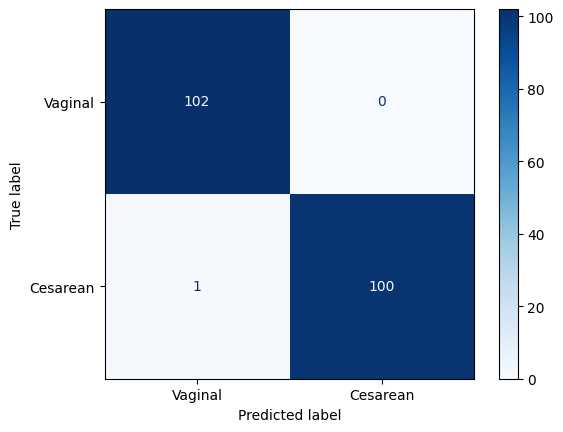

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = model.predict({'fetal_input': Xf_test, 'maternal_input': Xm_test})
y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Vaginal", "Cesarean"])
disp.plot(cmap='Blues')


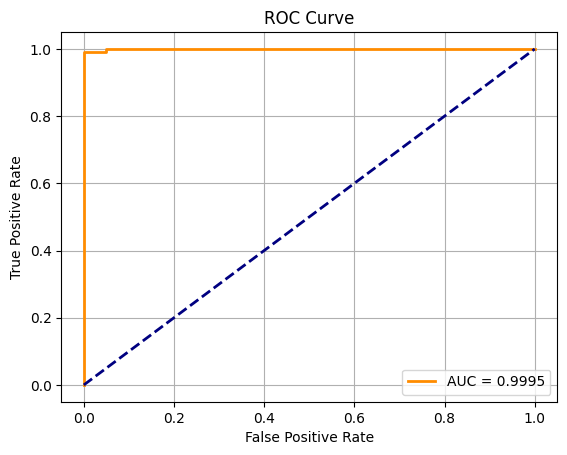

In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


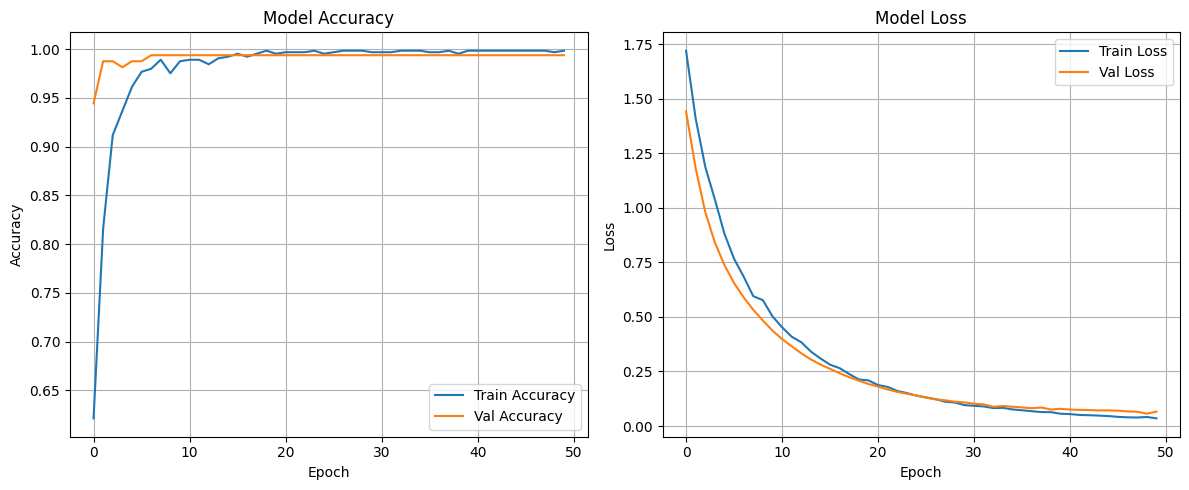

In [61]:
import matplotlib.pyplot as plt

# history: output from model.fit()
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
# history = model.fit(...)  # already done earlier
plot_training_history(history)


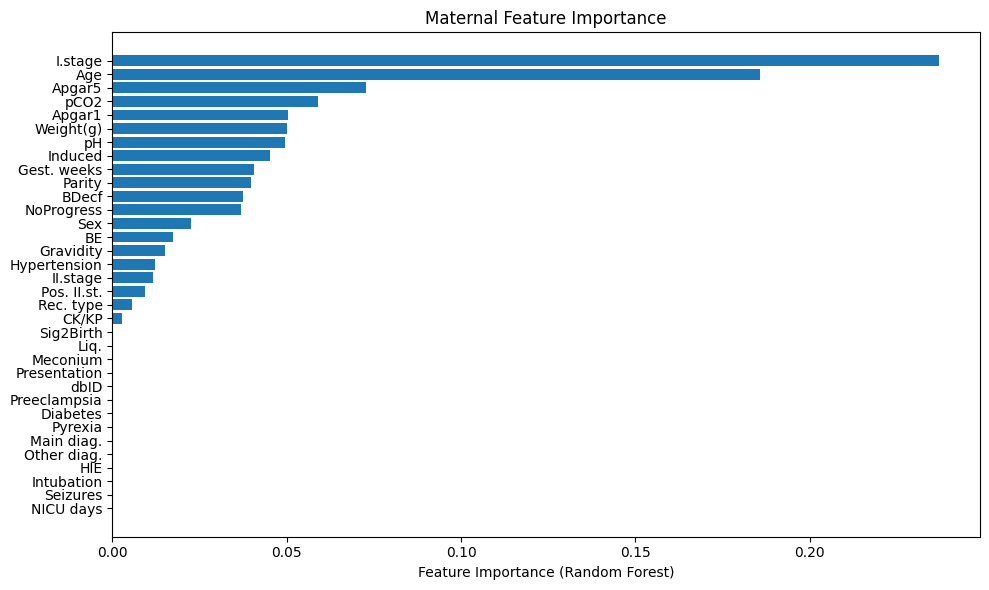

In [60]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Train a Random Forest on maternal features only
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(sample_Xm, sample_y)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 6))
plt.barh([maternal_features[i] for i in indices], importances[indices])
plt.xlabel("Feature Importance (Random Forest)")
plt.title("Maternal Feature Importance")
plt.tight_layout()
plt.show()


In [68]:
model.save("cnn_bilstm_model.keras")


In [69]:
from sklearn.preprocessing import StandardScaler
from joblib import dump

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_maternal)  # during training
dump(scaler, 'scaler.pkl')


['scaler.pkl']